### Critical windows with the causal RF: Analysis Phase 3 ("most realistic")
- The objective of this analysis phase it to perform tests which incorporate correlation between exposure over time. The causal RF may have greater difficulty recovering the effect of correlated exposures.  
- All models use a random draw of 5000 exposure profiles from the cohort's actual exposure profiles, with an outcome based on actual birth weight mean and df. One exposure is confounding the critical exposure(s).   

**Model 3.A:** a naive critical window  
- 6 exposures: 3 critical, 2 not critical, 1 confounder on critical exposures  
- CW is naive, with equal (i.e., constant) effects  

**Model 3.B:** a time-varying critical window  
- 6 exposures: 3 critical, 2 not critical, 1 confounder on critical exposures  
- CW is time-varying, with larger effects around a peak (e.g., high in weeks 2, 4; peak in week 3)  

**Model 3.C:** a concentrated critical exposure  
- 6 exposures: 1 critical, 4 not critical, 1 confounder on critical exposure  
- the exposure effect is concentrated (e.g., in week 3); i.e., the full effect of CW in model 1.C is concentrated in a single exposure  

In [249]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from econml.dml import LinearDML
from econml.dml import SparseLinearDML
from econml.dml import CausalForestDML
from sklearn.preprocessing import PolynomialFeatures

np.set_printoptions(suppress=True)

In [235]:
np.random.seed(1004) # use throughout

Cohort information
Get the mean and SD for ozone exposure and birth weight.

In [236]:
births = pd.read_csv("data/birth_clean_wide.csv")
births_long = pd.read_csv("data/birth_clean_long.csv")

o3_mean = births_long['max_o3'].mean()
o3_sd = births_long['max_o3'].std()

bw_mean = births["birthweightgrams"].mean()
bw_sd = births["birthweightgrams"].std()


#### Model 1.A
20 successive exposures: 3 critical, others not critical, 1 confounder on critical exposures

##### "Data"
A few conventions: `T` is treatments, `W` is confounders (aka controls), and `X` is features (includes confounders and covariates, but not treatment). For all models in this project, `X = W`, as there are no covariates, only confounders.

In [237]:
np.random.seed(1007)

n_samples = 5000 # 5000

n_X = 1
n_T = 20 # one critical, two not
n_W = 1 # one confounder

# features (in this case, confounders); z-scaled
X = np.random.normal(size = n_samples, loc = o3_mean, scale = o3_sd) / o3_sd
# treatments / exposures; z-scaled
T_sample = births.sample(n = n_samples, replace = False)

T_1 = (T_sample['max_o3_01'] - o3_mean) / o3_sd
T_2 = (T_sample['max_o3_02'] - o3_mean) / o3_sd
T_3 = (T_sample['max_o3_03'] - o3_mean) / o3_sd
T_4 = (T_sample['max_o3_04'] - o3_mean) / o3_sd
T_5 = (T_sample['max_o3_05'] - o3_mean) / o3_sd
T_6 = (T_sample['max_o3_06'] - o3_mean) / o3_sd
T_7 = (T_sample['max_o3_07'] - o3_mean) / o3_sd
T_8 = (T_sample['max_o3_08'] - o3_mean) / o3_sd
T_9 = (T_sample['max_o3_09'] - o3_mean) / o3_sd
T_10 = (T_sample['max_o3_10'] - o3_mean) / o3_sd
T_11 = (T_sample['max_o3_11'] - o3_mean) / o3_sd
T_12 = (T_sample['max_o3_12'] - o3_mean) / o3_sd
T_13 = (T_sample['max_o3_13'] - o3_mean) / o3_sd
T_14 = (T_sample['max_o3_14'] - o3_mean) / o3_sd
T_15 = (T_sample['max_o3_15'] - o3_mean) / o3_sd
T_16 = (T_sample['max_o3_16'] - o3_mean) / o3_sd
T_17 = (T_sample['max_o3_17'] - o3_mean) / o3_sd
T_18 = (T_sample['max_o3_18'] - o3_mean) / o3_sd
T_19 = (T_sample['max_o3_19'] - o3_mean) / o3_sd
T_20 = (T_sample['max_o3_20'] - o3_mean) / o3_sd


Look at correlation

In [238]:
T_vars = np.vstack((T_1, T_2, T_3, T_4, T_5,
                    T_6, T_7, T_8, T_9, T_10,
                    T_11, T_12, T_13, T_14, T_15,
                    T_16, T_17, T_18, T_19, T_20))
correlation_matrix = np.corrcoef(T_vars)
# print(correlation_matrix_np)

# correlation_matrix = T_vars.corr(numeric_only=True)

# plt.figure(figsize=(8, 6)) # Adjust figure size as needed
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=.5,
#             annot_kws={"size": 7})
# plt.title('Correlation Matrix Heatmap')
# plt.show()


Adjust the confounder so it is related to one treatment.

In [239]:
np.random.seed(1004)

## Confounder coefficient
b_W0T9 = 2.5
b_W0T10 = 2.5
b_W0T11 = 2.5
X = b_W0T9 * T_9 + b_W0T10 * T_10 + b_W0T11 * T_11 + np.random.normal(size=n_samples)
# z scale
X = X / X.std()
X = X.to_numpy()

# a 2.5-unit increase in the confounder increases the exposure by 1 unit
# this is done backwards (tx causes confounder) because later on, we'll use a real tx and synthetic confounder

In [240]:
# calculating hull for pdp
# will be useful in application

cond_10 = T["critical_tx_10"] <= -1
cond_9 = T["critical_tx_9"] <= -2
combined_condition = cond_9 & cond_10

print(len(T[combined_condition]))


# for i in [-2, -1, 0, 1, 2]:
#     for j in [-2, -1, 0, 1, 2]:
#         print("10 = " + str(i) + ", 9 =" + str(j))


#         cond_10 = T["critical_tx_10"] <= i
#         cond_9 = T["critical_tx_9"] <= j
#         combined_condition = cond_9 & cond_10

#         print(len(T[combined_condition]))

56


In [241]:
# plt.plot(X, T_1, 'o', alpha = 0.2, color = "black") # one example of unconfounded, noncritical tx
# plt.plot(X, T_8, 'o', alpha = 0.2, color = "darkblue") # one example of unconfounded, noncritical tx
# plt.plot(X, T_9, 'o', alpha = 0.2, color = "cornflowerblue") # confounded, critical tx
# plt.plot(X, T_10, 'o', alpha = 0.2, color = "cornflowerblue") # confounded, critical tx
# plt.plot(X, T_11, 'o', alpha = 0.2, color = "cornflowerblue") # confounded, critical tx
# plt.xlabel("Confounder")
# plt.ylabel("Treatments (z-scaled O3)")
# plt.show()

Create the critical window coefficients

In [242]:
study_period = np.linspace(1, 20, 20)
effect_size = -166 # lower threshold: 166; middle: 200-517; upper: 647
# the window should be 9 wide, then 7 wide, then 3 wide
window_start = 6
window_center = 10
window_end = 14

uni_pdf = stats.Uniform(a = window_start, b = window_end)
uni_wide_fx  = uni_pdf.pdf(study_period) * effect_size

uni_pdf = stats.Uniform(a = window_start + 1, b = window_end - 1)
uni_moderate_fx  = uni_pdf.pdf(study_period) * effect_size

uni_pdf = stats.Uniform(a = window_start + 3, b = window_end - 3)
uni_narrow_fx  = uni_pdf.pdf(study_period) * effect_size

norm_pdf = stats.norm.pdf(study_period, window_center, 2.5)
norm_wide_fx  = norm_pdf * effect_size 

norm_pdf = stats.norm.pdf(study_period, window_center, 1)
norm_moderate_fx  = norm_pdf * effect_size 

norm_pdf = stats.norm.pdf(study_period, window_center, 0.5)
norm_narrow_fx = norm_pdf * effect_size 

In [243]:
# get a list of treatment variables, to assign to coefficients
week_list = list(map(str, np.arange(1, 21)))
week_list = [str(num).zfill(2) for num in week_list]

T_vars_names = list(map(lambda item: "T_" + item, week_list))

Create the outcome using PDFs

In [244]:
norm_moderate_fx

array([ -0.        ,  -0.        ,  -0.        ,  -0.00000101,
        -0.0002468 ,  -0.02221582,  -0.73568684,  -8.96250044,
       -40.16714027, -66.22441855, -40.16714027,  -8.96250044,
        -0.73568684,  -0.02221582,  -0.0002468 ,  -0.00000101,
        -0.        ,  -0.        ,  -0.        ,  -0.        ])

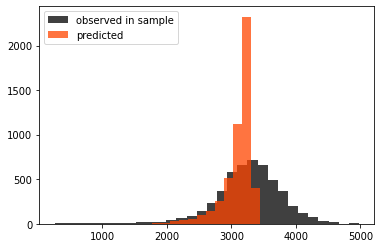

bw mean: 3260.2554276717005
y-hat mean 3113.338941438631
bw sd: 536.5732455330558
y-hat sd 230.68760272528664


In [245]:
# the coefficients and treatment variables
tx_fx, tx = norm_moderate_fx, T_vars
# the vectors of each coefficient * treatment variable
tx_fx_list = [tx[i] * tx_fx[i] for i in np.arange(8, 10)] #0, 20
# total treatment effect by individual
total_tx_fx = [sum(fx) for fx in zip(*tx_fx_list)]

# the confounder effect (z-scaled, see above)
b_W0y = -50
# the vector of confounder effects
wx_fx = X * b_W0y

# bit of noise
# 1:5 signal:noise; 166:830; sqrt(830) ~ 29
e = np.random.normal(size=n_samples, loc = 0, scale = 29)

# intercept
b_int = bw_mean

# interaction effect
b_intx = -200
intx_fx = b_intx * tx[8] * tx[9] #[b_intx * tx[i] for i in np.arange(8, 10)]

y = b_int + total_tx_fx + wx_fx + e + intx_fx


plt.hist(T_sample["birthweightgrams"], bins = 30,
         alpha = 0.75,# edgecolor = "white", 
         color = "black",
         label = "observed in sample")
plt.hist(y, bins = 12, alpha = 0.75,
         #edgecolor = "white",
         color = "orangered", 
         label = "predicted")
plt.legend(loc = 'upper left')
plt.show()

print("bw mean:", bw_mean)
print("y-hat mean", sum(y) / len(y))
print("bw sd:", bw_sd)
print("y-hat sd", np.std(y))

Correlation between exposures, outcome

In [246]:
# plt.plot(T_8, y, 'o', alpha = 0.2, color = "black") # noncritical tx in black
# plt.plot(T_15, y, 'o', alpha = 0.2, color = "darkblue") # noncritical tx in black
# plt.plot(T_9, y, 'o', alpha = 0.2, color = "cornflowerblue") # critical tx in blue
# plt.plot(T_10, y, 'o', alpha = 0.2, color = "cornflowerblue") # critical tx in blue
# plt.plot(T_11, y, 'o', alpha = 0.2, color = "cornflowerblue") # critical tx in blue
# plt.plot(X, y, 'o', alpha = 0.2, color = "darkviolet") # confounder in violet
# plt.xlabel("Treatments (z-scaled O3)")
# plt.ylabel("Birth weight (grams)")
# plt.show()

Matrices for treatments, confounders

In [277]:
T = pd.DataFrame({#'noncritical_tx_1': T_1, 'noncritical_tx_2': T_2, 
                #   'noncritical_tx_3': T_3, 'noncritical_tx_4': T_4, 
                #   'noncritical_tx_5': T_5, 'noncritical_tx_6': T_6, 
                #   'noncritical_tx_7': T_7, 'critical_tx_8': T_8, 
                  'critical_tx_9': T_9, 'critical_tx_10': T_10,
                     'critical_tx_11': T_11, 'critical_tx_12': T_12, 
                  'noncritical_tx_13': T_13, 'noncritical_tx_14': T_14, 
                  'noncritical_tx_15': T_15, 'noncritical_tx_16': T_16, 
                  'noncritical_tx_17': T_17, 'noncritical_tx_18': T_18, 
                #   'noncritical_tx_19': T_19, 'noncritical_tx_20': T_20#,
                   #'weeks9_and_10': tx[8] * tx[9]
                  })
X = pd.DataFrame(X, columns=['confounder'])
# X = pd.DataFrame({'gestation': T_sample['gestation']})
# y = pd.DataFrame({'birthweight': y})

##### Causal RF  

In [278]:
featurizer = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False, order = 'F')

X_interactions = featurizer.fit_transform(T)

test = SparseLinearDML(model_t='forest',
                      model_y='forest',
                      discrete_treatment=False,# treatment_featurizer=featurizer,
                      #n_estimators=500,# 
                      n_jobs = 4)

test.fit(y, T = X_interactions, X = X, W = X)
test.marginal_ate_inference(T, X)

,mean_point,stderr_mean,zstat,pvalue,ci_mean_lower,ci_mean_upper
T0,-42.899,2.308,-18.586,0.0,-47.423,-38.375
T1,-67.01,2.553,-26.247,0.0,-72.014,-62.006
T2,1.136,2.527,0.45,0.653,-3.817,6.09
T3,-2.426,2.143,-1.132,0.258,-6.626,1.773
T4,1.241,2.073,0.599,0.549,-2.822,5.304
T5,2.889,2.043,1.414,0.157,-1.116,6.893
T6,-1.205,2.008,-0.6,0.549,-5.14,2.731
T7,-2.298,1.977,-1.162,0.245,-6.173,1.577
T8,1.261,1.835,0.687,0.492,-2.335,4.857
T9,-0.269,1.585,-0.169,0.865,-3.376,2.839


In [228]:
featurizer = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False, order = 'F')

est = CausalForestDML(model_t='forest',
                      model_y='forest',
                      discrete_treatment=False,
                      n_estimators=500, treatment_featurizer=featurizer,
                      n_jobs = 4)

est.fit(y, T=T, X=X, W=X)
# takes 20-40 seconds w/ 5000
# takes 50-65 seconds w/ 10000
# second-order interactions:
## 6 variables: 13 s
## 8 variables: 23 s
## 10 variables: 39 s
## all should run in 13 m?

Extract the marginal effects

In [229]:
# takes 20-30 seconds

# est.marginal_effect_inference(T, X)
# test = est.marginal_effect_inference(T, X)
# test.population_summary()
# (T, X)
## -40.3 vs -40.1
## -65.2 vs. -66.2

est.marginal_ate_inference(T, X)

In [233]:
print(est.cate_treatment_names()) # all interact with all
est.const_marginal_ate_inference(X)

['critical_tx_9', 'critical_tx_10', 'critical_tx_9 critical_tx_10']


In [150]:
# Extract all values once
treatments = np.array(est.cate_treatment_names())
means = np.array(est.marginal_ate(T, X))
ci_lower, ci_upper = est.marginal_ate_interval(T, X)

# Construct DataFrame directly
res_df = pd.DataFrame({
    'treatment': treatments,
    'mean': means,
    'ci_lower': ci_lower,
    'ci_upper': ci_upper
})

res_df

ValueError: All arrays must be of the same length

Plot the marginal effects

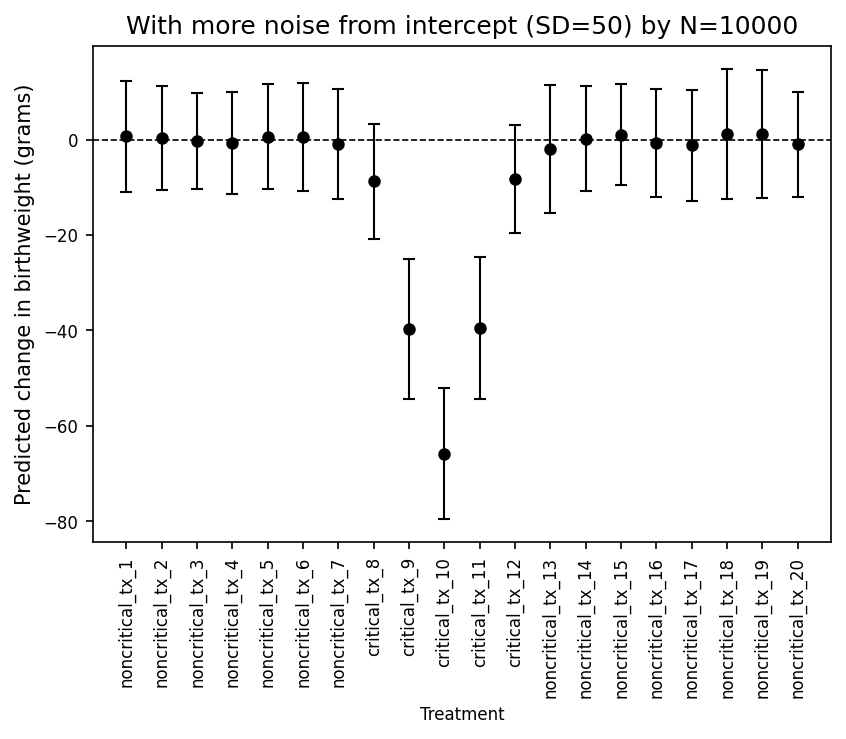

In [16]:
plt.figure(figsize=(6, 4), dpi=150)
# ci = np.array([res_df['ci_lower'] - res_df['mean'], res_df['mean'] - res_df['ci_upper'] ])
ci = np.array([res_df['mean'] - res_df['ci_lower'], res_df['ci_upper'] - res_df['mean']])
plt.errorbar(y = res_df['mean'], 
             x = res_df['treatment'], 
            yerr = ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axhline(y=0, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Treatment', fontsize=8)
plt.ylabel('Predicted change in birthweight (grams)')
plt.tight_layout()
plt.xticks(rotation=90)
plt.title("With more noise from intercept (SD=50) by N=10000")
# plt.savefig('raw_forest_plot.png')
plt.show()

Trying to recover interactions

In [124]:
# n_grid_pts = 5
grid_values_9 = [0, 1] #np.linspace(T["critical_tx_9"].min(), T["critical_tx_9"].max(), n_grid_pts)
grid_values_10 = [0, 1] #np.linspace(T["critical_tx_10"].min(), T["critical_tx_10"].max(), n_grid_pts)

partial_dependence_values = []#np.zeros((n_grid_pts, n_grid_pts))

for i in grid_values_9:
    for j in grid_values_10:
        # Create a copy of the original data
        X_temp = T.copy()
        # Set the feature of interest to the current grid value for all instances
        X_temp["critical_tx_9"] = i
        X_temp["critical_tx_10"] = j

        # T0_test = np.zeros((n_test, n_T))
        # T1_test = np.zeros((n_test, n_T))

        pred = est.effect(X, T0=0, T1 = X_temp)
        
        # est.fit(y, T=T, X=X, W=X)
        # est.effect(X, T0=X_temp)

        # Get predictions for the modified data
        predictions = pred.mean() #np.array(est.marginal_ate(X_temp, X)) #est.predict(X_temp) # est.effect(X_temp) 
        pred_025 = np.percentile(pred, 2.5)
        pred_975 = np.percentile(pred, 97.5)
        # Store the average prediction
        new_dat = {"tx_9": i, "tx_10": j, "pred": predictions, ".25": pred_025, ".975": pred_975}

        partial_dependence_values.append(new_dat)

partial_dependence_values

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/econml/_cate_estimator.py:893: UserWarning: A scalar was specified but there are multiple treatments; the same value will be used for each treatment.  Consider specifyingall treatments, or using the const_marginal_effect method.
  warn("A scalar was specified but there are multiple treatments; "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/econml/_cate_estimator.py:893: UserWarning: A scalar was specified but there are multiple treatments; the same value will be used for each treatment.  Consider specifyingall treatments, or using the const_marginal_effect method.
  warn("A scalar was specified but there are multiple treatments; "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/econml/_cate_estimator.py:893: UserWarning: A scalar was specified but there are multiple treatments; the same value will be used for each treatment.  Consider specif

[{'tx_9': 0, 'tx_10': 0, 'pred': 0.0, '.25': 0.0, '.975': 0.0},
 {'tx_9': 0,
  'tx_10': 1,
  'pred': -70.0873920126099,
  '.25': -102.16681971304814,
  '.975': -38.82953814529813},
 {'tx_9': 1,
  'tx_10': 0,
  'pred': -43.10346579311439,
  '.25': -73.30756521438026,
  '.975': -17.059850642884662},
 {'tx_9': 1,
  'tx_10': 1,
  'pred': -139.56598776509637,
  '.25': -233.23663065306673,
  '.975': -60.34370106549666}]

<Axes: xlabel='tx_10', ylabel='tx_9'>

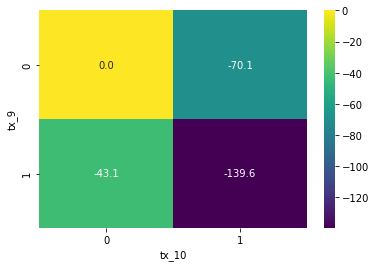

In [125]:
pdp_df = pd.DataFrame(partial_dependence_values)
pdp_df = pdp_df.sort_values(by = "tx_9", ascending = True)
ht_data = pdp_df.pivot(index = "tx_9", columns = "tx_10", values = "pred")

sns.heatmap(ht_data, annot = True, cmap = "viridis", fmt=".1f")